# Full revision analysis

## List of work to be performed:
1. Supplementary figure showing incorrect inform tumor segmentation and NKT cells 
2. Supplementary figure with zoom-in images of individual cells from inForm and TME-Analyzer in an image with high disagreement 
3. Incorporation of DeepCell into TME-Analyzer 
4. Reorganize the MonteCarlo trials 
5. Supplementary table 6 with full ranking of parameters and discovery/validation p values if top n parameters were used instead. 
6. Generate forest plot for 4E 
7. Build classifier based on train-test split of discovery cohort. Try 16-47, 32-31, 47-16 splits. 
8. ? It is significant amount of work, but since both reviewers mention is, I can train a random forest on the original dataset and report it ? 

## 5. Supplementary table 6 with full ranking of parameters and discovery/validation p values if top n parameters were used instead. 
We now provide a zip folder consisting of a 

5.1 a .png file plotting the Kaplan-Meier curves of patient groups; per classifier (a total of 3000 files, 70Mb).

5.2 the classifier performance based on top n parameters

start with recreating the plots in figure4

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test


c:\Users\balci\visual_code\TME-Analyzer\TME_Analyzer-resubmission\.venv\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
c:\Users\balci\visual_code\TME-Analyzer\TME_Analyzer-resubmission\.venv\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\balci\AppData\Local\Temp\ipykernel_22968\1030829388.py:180: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'border'][col_name[:col_name.find(' in border')]]))
C:\User

                     os  osi  classifier
BW-89-03894  236.681732  1.0        True
BW-89-06451  147.909653  0.0        True
DH-00-40510  163.351135  0.0        True
DH-00-42304  153.232040  1.0       False
DH-01-42006  117.059547  0.0        True
...                 ...  ...         ...
SC-94-00384  161.215607  0.0        True
SC-94-02625  199.162216  0.0        True
VL-89-00205  199.819305  0.0       False
ZR-89-02083   33.478439  1.0       False
ZZ-92-03670   76.418892  1.0       False

[63 rows x 3 columns]


Text(0.5, 0, 'years')

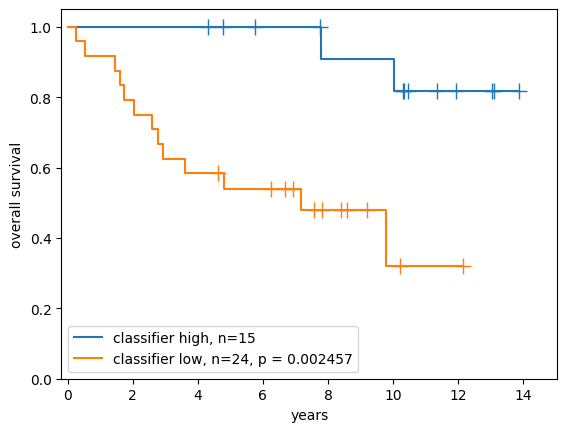

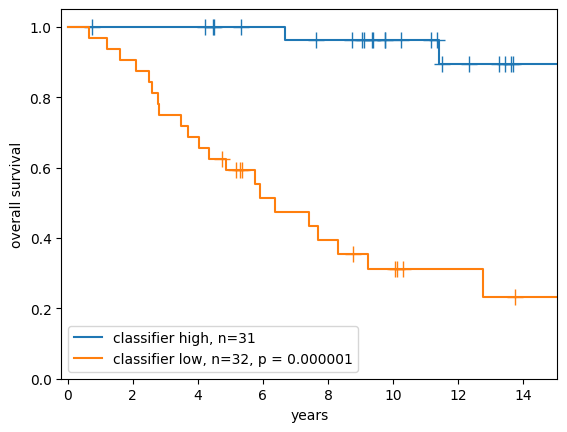

In [2]:
main_folder = 'E:/Moved from E/TME-Analyzer_the_manuscript/20211129_TME-Analyzer/'
input_folder = main_folder + '/ML/combination/'
output_folder = "E:/TME-Analyzer-large-files-from-desktop-folder/20231207_revision_files/Task5/"
auto_density_file = main_folder + '/data_analysis/output/validation_densities.xls'
auto_score_file = main_folder + '/data_analysis/output/normalized_distances.xls'
keren_density_file = main_folder + '/analysis_keren_et_al/validation/validation_densities.xls'
keren_score_file = main_folder + '/analysis_keren_et_al/validation/validation_scores.xls'
auto_clinical_file = 'E:/Moved from E/Dora effector/COX_analysis/survival without HER2 samples_mod.txt'
keren_clinical_file = 'E:/Desktop_backup_20231031/Desktop/TME-Analyzer_the_manuscript/images from keren et al/article_data_tables/1-s2.0-S0092867418311000-mmc2_mod.xlsx'
# validation_combined = "E:/Moved from E/TME-Analyzer_the_manuscript/20211129_TME-Analyzer/data_analysis/reproduction_of_old_analysis/20230712/validation_data.xlsx"
# data_frame_validation = pd.read_excel(validation_combined, engine='openpyxl')

clinical_data_raw = pd.read_excel(keren_clinical_file, engine='openpyxl')
clinical_data = pd.DataFrame(index = ['patient' + str(i+1) for i in range(41) if i not in [21,37]],columns = ['os','osi'])


for i in range(41):
    if i in [21,37]:
        continue
    pat_n = i+1
    clinical_data.loc['patient' + str(i+1),'os'] = clinical_data_raw[clinical_data_raw['InternalId']==pat_n]['Survival_days_capped*'].to_numpy()[0]
    clinical_data.loc['patient' + str(i+1),'osi'] = clinical_data_raw[clinical_data_raw['InternalId']==pat_n]['Censored'].to_numpy()[0] == 0

validation_multi = pd.DataFrame(index = clinical_data.index, columns = ['os','osi','classifier'])
validation_multi[['os','osi']] = clinical_data


data_frame = pd.read_csv(keren_density_file,sep='\t')
data_frame = data_frame.set_index(data_frame.keys()[0])
data_frame_orig = data_frame.copy()

pd_frame = pd.read_csv(keren_score_file,sep='\t')
pd_frame = pd_frame.set_index(pd_frame.keys()[0])

distance_index = ['patient' + i[i.find('Point')+5:i.find('.')] for i in pd_frame['sample id']]
distance_frame = pd_frame.iloc[:,1:]
# distance_frame = 1/distance_frame
# distance_frame[distance_frame.isna()] = 0
distance_frame.index = distance_index
data_frame = pd.concat((data_frame_orig,distance_frame),axis=1)

## in_center_classifier_10_validated_keys_validation

classifier_to_test = 'in_center_classifier_10_validated_keys'

px_size_dora = 0.4999
im_size_dora = 1352*1008
im_size_keren = 2048*2048
classifier_frame = pd.read_csv(input_folder + classifier_to_test + '.xls',sep='\t')
classifier_frame_new = pd.DataFrame(classifier_frame[['mean (good prognosis)', 'mean (bad prognosis)']])
classifier_frame_new.index = classifier_frame['Unnamed: 0']#,columns = ['mean (good prognosis)', 'mean (bad prognosis)'])

for i in classifier_frame_new.index:
    if 'area' in i:
        classifier_frame_new.loc[i] = classifier_frame_new.loc[i]*px_size_dora*px_size_dora#/im_size_dora*im_size_keren
    elif 'density' in i:
        classifier_frame_new.loc[i] = classifier_frame_new.loc[i]/px_size_dora/px_size_dora

new_index = []
for i in classifier_frame_new.index:
    if 'found' in i:
        new_index.append(i[:i.find('found')-1])
    else:
        new_index.append(i[:i[::-1].find('ni')*-1-3])
classifier_frame_new.index = new_index

data_frame_truncated = data_frame.loc[clinical_data.index,new_index]


all_tot_d = np.zeros((data_frame_truncated.shape[0],2))
for i in range(data_frame_truncated.shape[0]):
    temp_data = data_frame_truncated.iloc[i,:].copy().to_numpy()
    temp1 = classifier_frame_new['mean (bad prognosis)'].to_numpy()[temp_data==temp_data]
    temp2 = classifier_frame_new['mean (good prognosis)'].to_numpy()[temp_data==temp_data]
    temp_data = temp_data[temp_data == temp_data]
    all_tot_d[i,1] = np.sum(((temp_data - temp1)/(temp2-temp1))<0.5)
    all_tot_d[i,0] = np.sum(((temp_data - temp2)/(temp1-temp2))<0.5)
    all_tot_d[i] = all_tot_d[i] / np.sum(all_tot_d[i])


validation_multi.loc[data_frame_truncated.index,'classifier'] = all_tot_d[:,0]>np.median(all_tot_d[:,0])
i='classifier'
T1 = validation_multi['os'][validation_multi[i] == True]
E1 = validation_multi['osi'][validation_multi[i] == True]
T2 = validation_multi['os'][validation_multi[i] == False]
E2 = validation_multi['osi'][validation_multi[i] == False]
plt.figure()
kmf = KaplanMeierFitter()
kmf.fit(T1[T1==T1]/365,E1[T1==T1], label= 'classifier high, n=' + str(len(T1[T1==T1])))
a1 = kmf.plot(ci_show=False, show_censors=True,color='tab:blue')

temp = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
kmf.fit(T2[T2==T2]/365,E2[T2==T2], label= 'classifier low, n=' + str(len(T2[T2==T2])) + ', p = ' + format(temp.p_value, '.6f'))
a1 = kmf.plot(ci_show=False, show_censors=True,color='tab:orange')
a1.set_ylabel('overall survival')
a1.set_ylim(0,1.05)
a1.set_xlim(-0.2,15.05)
a1.set_xlabel('years')









classifier_to_test = 'in_center_classifier_10_validated_keys'
data_frame = pd.read_csv(auto_density_file,sep='\t')
clinical_data = pd.read_csv(auto_clinical_file,sep='\t')
clinical_data.index = clinical_data['sample']
data_frame.index = data_frame.iloc[:,0]
px_size_dora = 0.4999
try:
    classifier_frame = pd.read_excel(input_folder + classifier_to_test + '.xls')
except:
    classifier_frame = pd.read_csv(input_folder + classifier_to_test + '.xls',sep='\t')

# classifier_frame = pd.read_excel(input_folder + classifier_to_test + '.xls')

keys_to_keep = [1,1,1]
for i in data_frame.keys()[3:]:
    if 'auto' in i:
        keys_to_keep.append(1)
    else:
        keys_to_keep.append(0)

data_frame = data_frame.iloc[:,np.array(keys_to_keep)>0]

MSI_names = data_frame.iloc[:,0].to_numpy()

patients = []
for MSI in MSI_names:
    if MSI[:MSI.find(' ')] < MSI[:MSI.find('_')]:
        patients.append(MSI[:MSI.find(' ')])
    else:
        patients.append(MSI[:MSI.find('_')])

patients = np.unique(patients)



patients=list(patients)

for patient_index in patients:
    MSI_of_interest = []
    for MSI in MSI_names:
        if patient_index in MSI:
            MSI_of_interest.append(MSI)
    to_average = data_frame.loc[MSI_of_interest]
    if (np.sum(to_average['location'] == 'border') <3) & (np.sum(to_average['location'] == 'center') <3):
        patients.pop(patients.index(patient_index))

patients = np.array(patients)

# note ['FG-87-10839 excl_[48581,14771]_M2', 'IC-90-08870 infl_[41660,10828]_M2'] are dublicates
discovery_distances = pd.read_csv(auto_score_file,sep='\t')
# discovery_ids = [i[:i.find(']')+1] for i in discovery_distances['sample id']]
discovery_ids = [i[:i.find('_component')] for i in discovery_distances['sample id']]
discovery_distances.index = discovery_ids
discovery_distances = discovery_distances.iloc[:,2:]
data_frame = pd.concat((data_frame,discovery_distances),axis=1)

patient_cols = [i + ' in ' + j for i in data_frame.keys()[3:] for j in ['border','center','all']]


patient_frame = pd.DataFrame(index = patients, columns = patient_cols)


for patient_index in patients:
    MSI_of_interest = []
    for MSI in MSI_names:
        if patient_index in MSI:
            MSI_of_interest.append(MSI)
    to_average = data_frame.loc[MSI_of_interest]
    for col_name in patient_cols:
        if 'in all' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[col_name[:col_name.find(' in all')]]))
        elif 'in border' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'border'][col_name[:col_name.find(' in border')]]))
        elif 'in center' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'center'][col_name[:col_name.find(' in center')]]))

combined_data = clinical_data.loc[patient_frame.index][['mfsi','mfs','osi','os','dfsi','dfs']]
combined_data = pd.merge(combined_data,patient_frame, left_index=True, right_index=True)
combined_data = combined_data[combined_data['mfs'] == combined_data['mfs']]
combined_data['mfsi'] = combined_data['mfsi'] == 1
combined_data['osi'] = combined_data['osi'] == 1

significant_keys_gated = [i.replace('TME','auto') for i in classifier_frame.iloc[:,0]]


all_tot_d = np.zeros((combined_data.shape[0],2))
for i in range(combined_data.shape[0]):
    temp_data = combined_data.iloc[i,:][significant_keys_gated].copy().to_numpy()
    temp1 = classifier_frame['mean (bad prognosis)'].to_numpy()[temp_data==temp_data]
    temp2 = classifier_frame['mean (good prognosis)'].to_numpy()[temp_data==temp_data]
    temp_data = temp_data[temp_data == temp_data]
    all_tot_d[i,1] = np.sum(((temp_data - temp1)/(temp2-temp1))<0.5)
    all_tot_d[i,0] = np.sum(((temp_data - temp2)/(temp1-temp2))<0.5)
    all_tot_d[i] = all_tot_d[i] / np.sum(all_tot_d[i])

discovery_multi = pd.DataFrame(index=combined_data.index,columns = ['os','osi','classifier'])

discovery_multi[['os','osi']] = clinical_data.loc[combined_data.index,['os','osi']]
discovery_multi.loc[combined_data.index,'classifier'] = all_tot_d[:,0]>np.median(all_tot_d[:,0])

i='classifier'

T1 = discovery_multi['os'][discovery_multi[i] == True]
E1 = discovery_multi['osi'][discovery_multi[i] == True]
T2 = discovery_multi['os'][discovery_multi[i] == False]
E2 = discovery_multi['osi'][discovery_multi[i] == False]
plt.figure()
kmf = KaplanMeierFitter()
kmf.fit(T1[T1==T1]/12,E1[T1==T1], label= 'classifier high, n=' + str(len(T1[T1==T1])))
a1 = kmf.plot(ci_show=False, show_censors=True,color='tab:blue')

temp = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
kmf.fit(T2[T2==T2]/12,E2[T2==T2], label= 'classifier low, n=' + str(len(T2[T2==T2])) + ', p = ' + format(temp.p_value, '.6f'))
a1 = kmf.plot(ci_show=False, show_censors=True,color='tab:orange')
a1.set_ylabel('overall survival')
a1.set_ylim(0,1.05)
a1.set_xlim(-0.2,15.05)
a1.set_xlabel('years')




reload data

In [3]:
data_frame = pd.read_csv(auto_density_file,sep='\t')
clinical_data = pd.read_csv(auto_clinical_file,sep='\t')
clinical_data.index = clinical_data['sample']
data_frame.index = data_frame.iloc[:,0]
px_size_dora = 0.4999
try:
    classifier_frame = pd.read_excel(input_folder + classifier_to_test + '.xls')
except:
    classifier_frame = pd.read_csv(input_folder + classifier_to_test + '.xls',sep='\t')

# classifier_frame = pd.read_excel(input_folder + classifier_to_test + '.xls')

keys_to_keep = [1,1,1]
for i in data_frame.keys()[3:]:
    if 'auto' in i:
        keys_to_keep.append(1)
    else:
        keys_to_keep.append(0)

data_frame = data_frame.iloc[:,np.array(keys_to_keep)>0]

MSI_names = data_frame.iloc[:,0].to_numpy()

patients = []
for MSI in MSI_names:
    if MSI[:MSI.find(' ')] < MSI[:MSI.find('_')]:
        patients.append(MSI[:MSI.find(' ')])
    else:
        patients.append(MSI[:MSI.find('_')])

patients = np.unique(patients)



patients=list(patients)

for patient_index in patients:
    MSI_of_interest = []
    for MSI in MSI_names:
        if patient_index in MSI:
            MSI_of_interest.append(MSI)
    to_average = data_frame.loc[MSI_of_interest]
    if (np.sum(to_average['location'] == 'border') <3) & (np.sum(to_average['location'] == 'center') <3):
        patients.pop(patients.index(patient_index))

patients = np.array(patients)

# note ['FG-87-10839 excl_[48581,14771]_M2', 'IC-90-08870 infl_[41660,10828]_M2'] are dublicates
discovery_distances = pd.read_csv(auto_score_file,sep='\t')
# discovery_ids = [i[:i.find(']')+1] for i in discovery_distances['sample id']]
discovery_ids = [i[:i.find('_component')] for i in discovery_distances['sample id']]
discovery_distances.index = discovery_ids
discovery_distances = discovery_distances.iloc[:,2:]
data_frame = pd.concat((data_frame,discovery_distances),axis=1)

patient_cols = [i + ' in ' + j for i in data_frame.keys()[3:] for j in ['border','center','all']]


patient_frame = pd.DataFrame(index = patients, columns = patient_cols)


for patient_index in patients:
    MSI_of_interest = []
    for MSI in MSI_names:
        if patient_index in MSI:
            MSI_of_interest.append(MSI)
    to_average = data_frame.loc[MSI_of_interest]
    for col_name in patient_cols:
        if 'in all' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[col_name[:col_name.find(' in all')]]))
        elif 'in border' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'border'][col_name[:col_name.find(' in border')]]))
        elif 'in center' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'center'][col_name[:col_name.find(' in center')]]))

combined_data = clinical_data.loc[patient_frame.index][['mfsi','mfs','osi','os','dfsi','dfs']]
combined_data = pd.merge(combined_data,patient_frame, left_index=True, right_index=True)
combined_data = combined_data[combined_data['mfs'] == combined_data['mfs']]
combined_data['mfsi'] = combined_data['mfsi'] == 1
combined_data['osi'] = combined_data['osi'] == 1

data_frame = pd.read_csv(auto_density_file,sep='\t')
clinical_data = pd.read_csv(auto_clinical_file,sep='\t')
clinical_data.index = clinical_data['sample']
data_frame.index = data_frame.iloc[:,0]


keys_to_keep = [1,1,1]
for i in data_frame.keys()[3:]:
    if 'TME' in i:
        keys_to_keep.append(1)
    else:
        keys_to_keep.append(0)

data_frame = data_frame.iloc[:,np.array(keys_to_keep)>0]

MSI_names = data_frame.iloc[:,0].to_numpy()

patients = []
for MSI in MSI_names:
    if MSI[:MSI.find(' ')] < MSI[:MSI.find('_')]:
        patients.append(MSI[:MSI.find(' ')])
    else:
        patients.append(MSI[:MSI.find('_')])

patients = np.unique(patients)



patients=list(patients)

for patient_index in patients:
    MSI_of_interest = []
    for MSI in MSI_names:
        if patient_index in MSI:
            MSI_of_interest.append(MSI)
    to_average = data_frame.loc[MSI_of_interest]
    if (np.sum(to_average['location'] == 'border') <3) & (np.sum(to_average['location'] == 'center') <3):
        patients.pop(patients.index(patient_index))

patients = np.array(patients)

# note ['FG-87-10839 excl_[48581,14771]_M2', 'IC-90-08870 infl_[41660,10828]_M2'] are dublicates
discovery_distances = pd.read_csv(auto_score_file,sep='\t')
# discovery_ids = [i[:i.find(']')+1] for i in discovery_distances['sample id']]
discovery_ids = [i[:i.find('_component')] for i in discovery_distances['sample id']]
discovery_distances.index = discovery_ids
discovery_distances = discovery_distances.iloc[:,2:]
data_frame = pd.concat((data_frame,discovery_distances.loc[data_frame.index]),axis=1)

patient_cols = [i + ' in ' + j for i in data_frame.keys()[3:] for j in ['border','center','all']]


patient_frame = pd.DataFrame(index = patients, columns = patient_cols)


for patient_index in patients:
    MSI_of_interest = []
    for MSI in MSI_names:
        if patient_index in MSI:
            MSI_of_interest.append(MSI)
    to_average = data_frame.loc[MSI_of_interest]
    for col_name in patient_cols:
        if 'in all' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[col_name[:col_name.find(' in all')]]))
        elif 'in border' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'border'][col_name[:col_name.find(' in border')]]))
        elif 'in center' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'center'][col_name[:col_name.find(' in center')]]))

combined_data = clinical_data.loc[patient_frame.index][['mfsi','mfs','osi','os','dfsi','dfs']]
combined_data = pd.merge(combined_data,patient_frame, left_index=True, right_index=True)
combined_data = combined_data[combined_data['mfs'] == combined_data['mfs']]
combined_data['mfsi'] = combined_data['mfsi'] == 1
combined_data['osi'] = combined_data['osi'] == 1



C:\Users\balci\AppData\Local\Temp\ipykernel_22968\2812814970.py:72: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'border'][col_name[:col_name.find(' in border')]]))
C:\Users\balci\AppData\Local\Temp\ipykernel_22968\2812814970.py:74: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'center'][col_name[:col_name.find(' in center')]]))
C:\Users\balci\AppData\Local\Temp\ipykernel_22968\2812814970.py:70: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[col_name[:col_name.find(' in all')]]))


Index(['mfsi', 'mfs', 'osi', 'os', 'dfsi', 'dfs',
       'number of CD20 in All found by auto analysis in border',
       'number of CD20 in All found by auto analysis in center',
       'number of CD20 in All found by auto analysis in all',
       'density of CD20 in All found by auto analysis in border',
       ...
       'distance from CK to CD68 in Stroma+ in all',
       'distance from CK to CK in All in border',
       'distance from CK to CK in All in center',
       'distance from CK to CK in All in all',
       'distance from CK to CK in Tumor+ in border',
       'distance from CK to CK in Tumor+ in center',
       'distance from CK to CK in Tumor+ in all',
       'distance from CK to CK in Stroma+ in border',
       'distance from CK to CK in Stroma+ in center',
       'distance from CK to CK in Stroma+ in all'],
      dtype='object', length=483)


C:\Users\balci\AppData\Local\Temp\ipykernel_22968\2812814970.py:150: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'border'][col_name[:col_name.find(' in border')]]))
C:\Users\balci\AppData\Local\Temp\ipykernel_22968\2812814970.py:152: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'center'][col_name[:col_name.find(' in center')]]))
C:\Users\balci\AppData\Local\Temp\ipykernel_22968\2812814970.py:148: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[col_name[:col_name.find(' in all')]]))


Index(['mfsi', 'mfs', 'osi', 'os', 'dfsi', 'dfs',
       'number of CD20 in All found by TME analysis in border',
       'number of CD20 in All found by TME analysis in center',
       'number of CD20 in All found by TME analysis in all',
       'density of CD20 in All found by TME analysis in border',
       ...
       'distance from CK to CD68 in Stroma+ in all',
       'distance from CK to CK in All in border',
       'distance from CK to CK in All in center',
       'distance from CK to CK in All in all',
       'distance from CK to CK in Tumor+ in border',
       'distance from CK to CK in Tumor+ in center',
       'distance from CK to CK in Tumor+ in all',
       'distance from CK to CK in Stroma+ in border',
       'distance from CK to CK in Stroma+ in center',
       'distance from CK to CK in Stroma+ in all'],
      dtype='object', length=483)


remake the "classifier"

In [4]:
from time import time
import sklearn
import sklearn.model_selection

df = pd.read_csv(input_folder + 'key_abundance_validated.xls', sep='\t')
df = df.set_index(df.keys()[0])

#COX_keys = df.copy()

df = df.loc[[i for i in df.index if 'in center' in i]]
df = df.sort_values(by='abundance', ascending=False)


keys_to_test_all = df.index

for n_keys in range(len(keys_to_test_all)):
    pass
n_keys = len(keys_to_test_all)
n_keys+=1
keys_to_test = keys_to_test_all[:n_keys]

train_p_value = 0.05
significant_keys_tot = np.zeros((len(keys_to_test),2))
mean_values = np.zeros((len(keys_to_test),2))
pos_keys = np.zeros(len(keys_to_test))
neg_keys = np.zeros(len(keys_to_test))
pos_mean = np.zeros((len(keys_to_test),2))
neg_mean = np.zeros((len(keys_to_test),2))
pos_mean2 = np.zeros((len(keys_to_test),2))
neg_mean2 = np.zeros((len(keys_to_test),2))
mean2_values = np.zeros((len(keys_to_test),2))
t0 = time()

for i in range(1000):
    if i%10 == 0:
        print(n_keys,i,1,time()-t0,'seconds')
    train_set, test_set  = sklearn.model_selection.train_test_split(combined_data,test_size=51/63)
    for n_k, j in enumerate(keys_to_test):
        temp1 = train_set[train_set[j]<np.median(train_set[j])][j]
        temp2 = train_set[train_set[j]>np.median(train_set[j])][j]
        kmf = KaplanMeierFitter()
        T1 = clinical_data.loc[temp1.index]['os']
        E1 = clinical_data.loc[temp1.index]['osi']
        T2 = clinical_data.loc[temp2.index]['os']
        E2 = clinical_data.loc[temp2.index]['osi']
        if (len(T1) == 0) | (len(T2) == 0):
            continue
        temp = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
        p = temp.p_value
        if (p==p) & (p < train_p_value):
            mean_values[n_k,:] = mean_values[n_k,:] + [np.mean(temp1),np.mean(temp2)]
            if (np.mean(T2)>np.mean(T1)):
                pos_keys[n_k] = pos_keys[n_k] +1
                significant_keys_tot[n_k] = significant_keys_tot[n_k] + 1
                pos_mean[n_k,:] = pos_mean[n_k,:] + [np.mean(temp1),np.mean(temp2)]
                pos_mean2[n_k,:] = pos_mean2[n_k,:] + [np.mean(temp1)**2,np.mean(temp2)**2]
            else:
                neg_keys[n_k] = neg_keys[n_k] +1
                significant_keys_tot[n_k] = significant_keys_tot[n_k] +1
                neg_mean[n_k,:] = neg_mean[n_k,:] + [np.mean(temp2),np.mean(temp1)]
                neg_mean2[n_k,:] = neg_mean2[n_k,:] + [np.mean(temp2)**2,np.mean(temp1)**2]

mean_values = mean_values/significant_keys_tot
significant_keys_init = significant_keys_tot.copy()
pos_mean[:,0] = pos_mean[:,0]/pos_keys
pos_mean[:,1] = pos_mean[:,1]/pos_keys
neg_mean[:,0] = neg_mean[:,0]/neg_keys
neg_mean[:,1] = neg_mean[:,1]/neg_keys
pos_mean2[:,0] = pos_mean2[:,0]/pos_keys
pos_mean2[:,1] = pos_mean2[:,1]/pos_keys
neg_mean2[:,0] = neg_mean2[:,0]/neg_keys
neg_mean2[:,1] = neg_mean2[:,1]/neg_keys


pos_neg_amount = 0.5
significant_keys_tot = significant_keys_init.copy()
for i in range(len(pos_keys)):
    if significant_keys_tot[i,0]*pos_neg_amount <= pos_keys[i]:
        significant_keys_tot[i,:] = pos_keys[i]
        mean_values[i,:] = pos_mean[i,:]
        mean2_values[i,:] = pos_mean2[i,:]
    elif significant_keys_tot[i,0]*pos_neg_amount <= neg_keys[i]:
        significant_keys_tot[i,:] = neg_keys[i]
        mean_values[i,:] = neg_mean[i,:]
        mean2_values[i,:] = neg_mean2[i,:]
    else:
        significant_keys_tot[i,:] = 0

significant_keys_gated = keys_to_test
mean1 = np.zeros(len(significant_keys_gated))
mean2 = np.zeros(len(significant_keys_gated))
std1 = np.zeros(len(significant_keys_gated))
std2 = np.zeros(len(significant_keys_gated))
for i,j in enumerate(significant_keys_gated):
    if (mean_values[i,0] == mean_values[i,0]) & (mean_values[i,1] == mean_values[i,1]):
        mean1[i] = mean_values[i,0]
        mean2[i] = mean_values[i,1]
        std1[i] = (mean2_values[i,0] - mean1[i]**2)**0.5
        std2[i] = (mean2_values[i,1] - mean2[i]**2)**0.5




all_tot_d = np.zeros((combined_data.shape[0],2))
for i in range(combined_data.shape[0]):
    temp_data = combined_data.iloc[i,:][significant_keys_gated].copy().to_numpy()
    temp1 = mean1[temp_data==temp_data][:n_keys]
    temp2 = mean2[temp_data==temp_data][:n_keys]
    temp_data = temp_data[temp_data == temp_data][:n_keys]
    all_tot_d[i,1] = np.sum(((temp_data - temp1)/(temp2-temp1))<0.5)
    all_tot_d[i,0] = np.sum(((temp_data - temp2)/(temp1-temp2))<0.5)
    all_tot_d[i] = all_tot_d[i] / np.sum(all_tot_d[i])


output_table = pd.DataFrame(index = keys_to_test, columns = ['mean (good prognosis)','mean (bad prognosis)','std (good prognosis)','std (bad prognosis)','abundance'])

for n_k, i in enumerate(keys_to_test):
    output_table.loc[i,'mean (good prognosis)'] = mean2[n_k]
    output_table.loc[i,'mean (bad prognosis)'] = mean1[n_k]
    output_table.loc[i,'std (good prognosis)'] = std2[n_k]
    output_table.loc[i,'std (bad prognosis)'] = std1[n_k]
    output_table.loc[i,'abundance'] = df.loc[i,'abundance']


output_table.to_excel(output_folder + 'in_center_classifier_all_keys.xls')




51 0 1 0.0 seconds
51 10 1 6.194808721542358 seconds
51 20 1 12.529669761657715 seconds
51 30 1 18.618900537490845 seconds
51 40 1 24.54750370979309 seconds
51 50 1 31.635939836502075 seconds
51 60 1 38.36125135421753 seconds
51 70 1 45.25411915779114 seconds
51 80 1 51.39484930038452 seconds
51 90 1 56.811511516571045 seconds
51 100 1 64.4654278755188 seconds
51 110 1 71.56701707839966 seconds
51 120 1 78.722487449646 seconds
51 130 1 84.17168021202087 seconds
51 140 1 90.05265522003174 seconds
51 150 1 96.81640577316284 seconds
51 160 1 103.96253085136414 seconds
51 170 1 109.69278311729431 seconds
51 180 1 115.84073448181152 seconds
51 190 1 121.44877982139587 seconds
51 200 1 128.4405426979065 seconds
51 210 1 135.38986706733704 seconds
51 220 1 140.81904435157776 seconds
51 230 1 147.22175431251526 seconds
51 240 1 153.16019558906555 seconds
51 250 1 159.6431543827057 seconds
51 260 1 165.82115411758423 seconds
51 270 1 171.6539387702942 seconds
51 280 1 178.03322458267212 seconds

incorporate the original classifier

In [29]:
# the_classifier = pd.read_csv(input_folder + 'in_center_classifier_10_validated_keys.xls',sep='\t')
# the_classifier = pd.DataFrame(the_classifier[['mean (good prognosis)', 'mean (bad prognosis)']]).set_index(the_classifier['Unnamed: 0'])

# for n_k, i in enumerate(the_classifier.index):
#     output_table.loc[i,'mean (good prognosis)'] = the_classifier.loc[i,'mean (good prognosis)']
#     output_table.loc[i,'mean (bad prognosis)'] = the_classifier.loc[i,'mean (bad prognosis)']


# output_table.to_excel(output_folder + 'in_center_classifiers.xls')

new_index = []
for i in output_table.index:
    new_index.append(i.replace('CD3 CD8','CD8').replace('CD3','CD4').replace(' in All','').replace(' in center','').replace(' found by TME analysis','').replace('from','of'))

output_table.set_index(np.array(new_index)).to_excel(output_folder + 'Supplementary_table_X.xls')

output_table.iloc[:10,:].to_excel(output_folder + 'in_center_classifier_10_validated_keys.xls')

make KM curves for all validation

In [31]:
clinical_data_raw = pd.read_excel(keren_clinical_file, engine='openpyxl')
clinical_data = pd.DataFrame(index = ['patient' + str(i+1) for i in range(41) if i not in [21,37]],columns = ['os','osi'])


for i in range(41):
    if i in [21,37]:
        continue
    pat_n = i+1
    clinical_data.loc['patient' + str(i+1),'os'] = clinical_data_raw[clinical_data_raw['InternalId']==pat_n]['Survival_days_capped*'].to_numpy()[0]
    clinical_data.loc['patient' + str(i+1),'osi'] = clinical_data_raw[clinical_data_raw['InternalId']==pat_n]['Censored'].to_numpy()[0] == 0

validation_multi = pd.DataFrame(index = clinical_data.index, columns = ['os','osi','classifier'])
validation_multi[['os','osi']] = clinical_data


data_frame = pd.read_csv(keren_density_file,sep='\t')
data_frame = data_frame.set_index(data_frame.keys()[0])
data_frame_orig = data_frame.copy()

pd_frame = pd.read_csv(keren_score_file,sep='\t')
pd_frame = pd_frame.set_index(pd_frame.keys()[0])

distance_index = ['patient' + i[i.find('Point')+5:i.find('.')] for i in pd_frame['sample id']]
distance_frame = pd_frame.iloc[:,1:]
distance_frame.index = distance_index
data_frame = pd.concat((data_frame_orig,distance_frame),axis=1)

px_size_dora = 0.4999
im_size_dora = 1352*1008
im_size_keren = 2048*2048
classifier_frame = pd.read_excel(output_folder + 'in_center_classifier_all_keys.xls')
classifier_frame = pd.read_excel(output_folder + 'in_center_classifier_10_validated_keys.xls')
classifier_frame = pd.DataFrame(classifier_frame[['mean (good prognosis)', 'mean (bad prognosis)']]).set_index(classifier_frame['Unnamed: 0'])

for i in classifier_frame.index:
    if 'area' in i:
        classifier_frame.loc[i] = classifier_frame.loc[i]*px_size_dora*px_size_dora#/im_size_dora*im_size_keren
    elif 'density' in i:
        classifier_frame.loc[i] = classifier_frame.loc[i]/px_size_dora/px_size_dora

new_index = []
for i in classifier_frame.index:
    if 'found' in i:
        new_index.append(i[:i.find('found')-1])
    else:
        new_index.append(i[:i[::-1].find('ni')*-1-3])

for n_keys in range(len(new_index)):
    n_keys+=1
    data_frame_truncated = data_frame.loc[clinical_data.index,new_index[:n_keys]]
    classifier_frame_new = classifier_frame.iloc[:n_keys,:]    
    all_tot_d = np.zeros((data_frame_truncated.shape[0],2))
    for i in range(data_frame_truncated.shape[0]):
        temp_data = data_frame_truncated.iloc[i,:].copy().to_numpy()
        temp1 = classifier_frame_new['mean (bad prognosis)'].to_numpy()[temp_data==temp_data]
        temp2 = classifier_frame_new['mean (good prognosis)'].to_numpy()[temp_data==temp_data]
        temp_data = temp_data[temp_data == temp_data]
        all_tot_d[i,1] = np.sum(((temp_data - temp1)/(temp2-temp1))<0.5)
        all_tot_d[i,0] = np.sum(((temp_data - temp2)/(temp1-temp2))<0.5)
        all_tot_d[i] = all_tot_d[i] / np.sum(all_tot_d[i])


    validation_multi.loc[data_frame_truncated.index,'classifier'] = all_tot_d[:,0]>np.nanmedian(all_tot_d[:,0])
    i='classifier'
    T1 = validation_multi['os'][validation_multi[i] == True]
    if (len(T1) <= 1):
        validation_multi.loc[data_frame_truncated.index,'classifier'] = all_tot_d[:,0]>=np.nanmedian(all_tot_d[:,0])
        # print(np.median(all_tot_d[:,0]))
        T1 = validation_multi['os'][validation_multi[i] == True]
    E1 = validation_multi['osi'][validation_multi[i] == True]
    T2 = validation_multi['os'][validation_multi[i] == False]
    E2 = validation_multi['osi'][validation_multi[i] == False]

    plt.figure()
    # print(len(T1),validation_multi)
    kmf = KaplanMeierFitter()
    kmf.fit(T1[T1==T1]/365,E1[T1==T1], label= 'classifier high, n=' + str(len(T1[T1==T1])))
    a1 = kmf.plot(ci_show=False, show_censors=True,color='tab:blue')

    temp = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
    kmf.fit(T2[T2==T2]/365,E2[T2==T2], label= 'classifier low, n=' + str(len(T2[T2==T2])) + ', p = ' + format(temp.p_value, '.6f'))
    a1 = kmf.plot(ci_show=False, show_censors=True,color='tab:orange')
    a1.set_ylabel('overall survival')
    a1.set_ylim(0,1.05)
    a1.set_xlim(-0.2,15.05)
    a1.set_xlabel('years')
    plt.savefig(output_folder + 'top_' + str(n_keys) + '_keys_validation.png')
    plt.close('all')




c:\Users\balci\visual_code\TME-Analyzer\TME_Analyzer-resubmission\.venv\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
c:\Users\balci\visual_code\TME-Analyzer\TME_Analyzer-resubmission\.venv\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
c:\Users\balci\visual_code\TME-Analyzer\TME_Analyzer-resubmission\.venv\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do con

make KM curves for all discovery

In [32]:
data_frame = pd.read_csv(auto_density_file,sep='\t')
clinical_data = pd.read_csv(auto_clinical_file,sep='\t')
clinical_data.index = clinical_data['sample']
data_frame.index = data_frame.iloc[:,0]
px_size_dora = 0.4999

classifier_frame = pd.read_excel(output_folder + 'in_center_classifier_all_keys.xls')

keys_to_keep = [1,1,1]
for i in data_frame.keys()[3:]:
    if 'auto' in i:
        keys_to_keep.append(1)
    else:
        keys_to_keep.append(0)

data_frame = data_frame.iloc[:,np.array(keys_to_keep)>0]

MSI_names = data_frame.iloc[:,0].to_numpy()

patients = []
for MSI in MSI_names:
    if MSI[:MSI.find(' ')] < MSI[:MSI.find('_')]:
        patients.append(MSI[:MSI.find(' ')])
    else:
        patients.append(MSI[:MSI.find('_')])

patients = np.unique(patients)



patients=list(patients)

for patient_index in patients:
    MSI_of_interest = []
    for MSI in MSI_names:
        if patient_index in MSI:
            MSI_of_interest.append(MSI)
    to_average = data_frame.loc[MSI_of_interest]
    if (np.sum(to_average['location'] == 'border') <3) & (np.sum(to_average['location'] == 'center') <3):
        patients.pop(patients.index(patient_index))

patients = np.array(patients)

# note ['FG-87-10839 excl_[48581,14771]_M2', 'IC-90-08870 infl_[41660,10828]_M2'] are dublicates
discovery_distances = pd.read_csv(auto_score_file,sep='\t')
# discovery_ids = [i[:i.find(']')+1] for i in discovery_distances['sample id']]
discovery_ids = [i[:i.find('_component')] for i in discovery_distances['sample id']]
discovery_distances.index = discovery_ids
discovery_distances = discovery_distances.iloc[:,2:]
data_frame = pd.concat((data_frame,discovery_distances),axis=1)

patient_cols = [i + ' in ' + j for i in data_frame.keys()[3:] for j in ['border','center','all']]


patient_frame = pd.DataFrame(index = patients, columns = patient_cols)


for patient_index in patients:
    MSI_of_interest = []
    for MSI in MSI_names:
        if patient_index in MSI:
            MSI_of_interest.append(MSI)
    to_average = data_frame.loc[MSI_of_interest]
    for col_name in patient_cols:
        if 'in all' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[col_name[:col_name.find(' in all')]]))
        elif 'in border' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'border'][col_name[:col_name.find(' in border')]]))
        elif 'in center' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'center'][col_name[:col_name.find(' in center')]]))

combined_data = clinical_data.loc[patient_frame.index][['mfsi','mfs','osi','os','dfsi','dfs']]
combined_data = pd.merge(combined_data,patient_frame, left_index=True, right_index=True)
combined_data = combined_data[combined_data['mfs'] == combined_data['mfs']]
combined_data['mfsi'] = combined_data['mfsi'] == 1
combined_data['osi'] = combined_data['osi'] == 1


for n_keys in range(len(new_index)):
    n_keys+=1
    classifier_frame_new = classifier_frame.iloc[:n_keys,:]    
    significant_keys_gated = [i.replace('TME','auto') for i in classifier_frame_new.iloc[:,0]]
    all_tot_d = np.zeros((combined_data.shape[0],2))
    for i in range(combined_data.shape[0]):
        temp_data = combined_data.iloc[i,:][significant_keys_gated].copy().to_numpy()
        temp1 = classifier_frame_new['mean (bad prognosis)'].to_numpy()[temp_data==temp_data]
        temp2 = classifier_frame_new['mean (good prognosis)'].to_numpy()[temp_data==temp_data]
        temp_data = temp_data[temp_data == temp_data]
        all_tot_d[i,1] = np.sum(((temp_data - temp1)/(temp2-temp1))<0.5)
        all_tot_d[i,0] = np.sum(((temp_data - temp2)/(temp1-temp2))<0.5)
        all_tot_d[i] = all_tot_d[i] / np.sum(all_tot_d[i])

    discovery_multi = pd.DataFrame(index=combined_data.index,columns = ['os','osi','classifier'])

    discovery_multi[['os','osi']] = clinical_data.loc[combined_data.index,['os','osi']]
    discovery_multi.loc[combined_data.index,'classifier'] = all_tot_d[:,0]>np.nanmedian(all_tot_d[:,0])

    i='classifier'

    T1 = discovery_multi['os'][discovery_multi[i] == True]
    if (len(T1) <= 1):
        discovery_multi.loc[combined_data.index,'classifier'] = all_tot_d[:,0]>=np.nanmedian(all_tot_d[:,0])
        T1 = discovery_multi['os'][discovery_multi[i] == True]
    E1 = discovery_multi['osi'][discovery_multi[i] == True]
    T2 = discovery_multi['os'][discovery_multi[i] == False]
    E2 = discovery_multi['osi'][discovery_multi[i] == False]
    # print(discovery_multi)
    plt.figure()
    kmf = KaplanMeierFitter()
    kmf.fit(T1[T1==T1]/12,E1[T1==T1], label= 'classifier high, n=' + str(len(T1[T1==T1])))
    a1 = kmf.plot(ci_show=False, show_censors=True,color='tab:blue')

    temp = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
    kmf.fit(T2[T2==T2]/12,E2[T2==T2], label= 'classifier low, n=' + str(len(T2[T2==T2])) + ', p = ' + format(temp.p_value, '.6f'))
    a1 = kmf.plot(ci_show=False, show_censors=True,color='tab:orange')
    a1.set_ylabel('overall survival')
    a1.set_ylim(0,1.05)
    a1.set_xlim(-0.2,15.05)
    a1.set_xlabel('years')
    plt.savefig(output_folder + 'top_' + str(n_keys) + '_keys_discovery.png')
    plt.close('all')



C:\Users\balci\AppData\Local\Temp\ipykernel_22968\1793906017.py:68: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'border'][col_name[:col_name.find(' in border')]]))
C:\Users\balci\AppData\Local\Temp\ipykernel_22968\1793906017.py:70: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'center'][col_name[:col_name.find(' in center')]]))
C:\Users\balci\AppData\Local\Temp\ipykernel_22968\1793906017.py:66: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[col_name[:col_name.find(' in all')]]))
